In [1]:
# !pip install ray==0.8.7
# !pip install ray[tune,rllib]
# !pip install symfit
# !pip install dm-tree
# !pip install opencv-python
# !pip install tensorboardX
# !pip install torch torchvision

In [2]:
from tensortrade.oms.instruments import Instrument
import pandas as pd

USD = Instrument("USD", 6, "U.S. Dollar")
CAD = Instrument("CAD", 6, "Canadian Dollar")

df = pd.read_csv('data/USD_CAD_H4_2021-05-07.csv')

df.describe()


,open,high,low,close,volume
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.318374,1.319967,1.316767,1.318357,7230.880200
std,0.036112,0.036399,0.035814,0.036127,7389.247272
min,1.215230,1.215970,1.212690,1.213680,1.000000
25%,1.299422,1.300977,1.297720,1.299392,2210.750000
50%,1.318335,1.319745,1.316970,1.318290,4609.000000
75%,1.333775,1.334937,1.332330,1.333712,9545.000000
max,1.462440,1.467060,1.454140,1.462470,59501.000000


<AxesSubplot:>

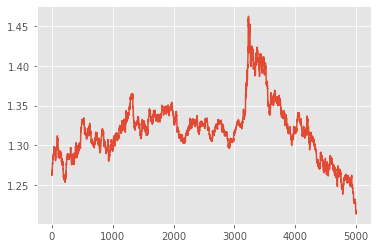

In [3]:
df['close'].plot()

In [4]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [5]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position * 10000).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [6]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [7]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

def create_env(config):

    p = Stream.source(df['close'] , dtype="float").rename("CAD-USD")

    USD = Instrument("USD", 6, "U.S. Dollar")
    CAD = Instrument("CAD", 6, "Canadian Dollar")

    oanda = Exchange("oanda", service=execute_order)(
                p
            )

    cash = Wallet(oanda, 10000 * CAD)
    asset = Wallet(oanda, 0 * USD)

    portfolio = Portfolio(CAD, [
        cash,
        asset
    ])
    # p_ = p * 10000
    feed = DataFeed([
        # p_,
        # p_.rolling(window=10).mean().rename("fast"),
        # p_.rolling(window=50).mean().rename("medium"),
        # p_.rolling(window=100).mean().rename("slow"),
        # p_.log().diff().fillna(0).rename("lr")
        Stream.source(df['close']*10000, dtype="float").rename("close"),
       Stream.source(df['open']*10000, dtype="float").rename("open"),
       Stream.source(df['high']*10000, dtype="float").rename("high"),
       Stream.source(df['low']*10000, dtype="float").rename("low"),
       Stream.source(df['volume'], dtype="float").rename("volume"),
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [8]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 2000
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "INFO",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-05-11 07:49:10,724	INFO resource_spec.py:223 -- Starting Ray with 1.86 GiB memory available for workers and up to 0.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-11 07:49:11,348	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_0f21c_00000,RUNNING,


(pid=972) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=972) Instructions for updating:
(pid=972) non-resource variables are not supported in the long term
(pid=972) 2021-05-11 07:49:34,815	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fb8fd5a0eb0>}
(pid=972) 2021-05-11 07:49:34,815	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fb8fd5a01f0>}
(pid=972) 2021-05-11 07:49:34,815	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=972) 2021-05-11 07:49:34,886	WARNING u

Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-50-07
  done: false
  episode_len_mean: 341.27272727272725
  episode_reward_max: 552.2000000000189
  episode_reward_mean: -21.13636363635817
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 11
  episodes_total: 11
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.6743252668529749
        entropy_coeff: 0.01
        kl: 0.01916829709080048
        policy_loss: -0.03725884418236092
        total_loss: 0.45538522582501173
        vf_explained_var: 0.006041368469595909
        vf_loss: 0.9911073185503483
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.7

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,1,32.1262,4000,-21.1364


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-50-25
  done: false
  episode_len_mean: 348.3636363636364
  episode_reward_max: 770.3999999999887
  episode_reward_mean: 87.09090909091542
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 11
  episodes_total: 22
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 0.0007000000000000001
        entropy: 0.6189720332622528
        entropy_coeff: 0.01
        kl: 0.02375516976462677
        policy_loss: -0.05020646608318202
        total_loss: 0.4412589417770505
        vf_explained_var: 0.009524991735816002
        vf_loss: 0.9858081992715597
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_pe

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,2,50.8424,8000,87.0909


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-50-44
  done: false
  episode_len_mean: 364.03125
  episode_reward_max: 1421.1000000000195
  episode_reward_mean: 243.74687500000346
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 10
  episodes_total: 32
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.00030000000000000003
        entropy: 0.5521423369646072
        entropy_coeff: 0.01
        kl: 0.01689001204795204
        policy_loss: -0.044472801964730024
        total_loss: 0.4385366798378527
        vf_explained_var: 0.027456136420369148
        vf_loss: 0.9669278133660555
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,3,69.8695,12000,243.747


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-51-00
  done: false
  episode_len_mean: 387.1463414634146
  episode_reward_max: 1464.0999999999835
  episode_reward_mean: 430.2292682926851
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 9
  episodes_total: 41
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 9.800000000000001e-05
        entropy: 0.4791796961799264
        entropy_coeff: 0.01
        kl: 0.013726482633501291
        policy_loss: -0.03566528746159747
        total_loss: 0.4341162871569395
        vf_explained_var: 0.047000303864479065
        vf_loss: 0.9409108608961105
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  pe

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,4,85.4151,16000,430.229


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-51-15
  done: false
  episode_len_mean: 406.0816326530612
  episode_reward_max: 2140.900000000013
  episode_reward_mean: 597.8612244897962
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 8
  episodes_total: 49
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 9.400000000000001e-05
        entropy: 0.41419449262320995
        entropy_coeff: 0.01
        kl: 0.009503524343017489
        policy_loss: -0.028139752947026864
        total_loss: 0.43311787908896804
        vf_explained_var: 0.058492064476013184
        vf_loss: 0.9250970464199781
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,5,100.854,20000,597.861


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-51-31
  done: false
  episode_len_mean: 425.80357142857144
  episode_reward_max: 2728.1000000000245
  episode_reward_mean: 797.5124999999989
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 56
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 9.0e-05
        entropy: 0.3615528428927064
        entropy_coeff: 0.01
        kl: 0.006125257394160144
        policy_loss: -0.019858682760968804
        total_loss: 0.42844772059470415
        vf_explained_var: 0.06896853446960449
        vf_loss: 0.9001687169075012
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,6,116.035,24000,797.512


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-51-46
  done: false
  episode_len_mean: 440.6031746031746
  episode_reward_max: 2728.1000000000245
  episode_reward_mean: 943.9333333333311
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 63
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 8.6e-05
        entropy: 0.319586630910635
        entropy_coeff: 0.01
        kl: 0.006432048627175391
        policy_loss: -0.015465651522390544
        total_loss: 0.4340654341503978
        vf_explained_var: 0.07436825335025787
        vf_loss: 0.901594664901495
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,7,131.228,28000,943.933


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-52-09
  done: false
  episode_len_mean: 451.98571428571427
  episode_reward_max: 2936.1000000000117
  episode_reward_mean: 1095.7142857142826
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 70
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 8.2e-05
        entropy: 0.29171683453023434
        entropy_coeff: 0.01
        kl: 0.0034599816353875212
        policy_loss: -0.012570002567372285
        total_loss: 0.4165318696759641
        vf_explained_var: 0.09638099372386932
        vf_loss: 0.861962104216218
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,8,154.857,32000,1095.71


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-52-25
  done: false
  episode_len_mean: 462.85714285714283
  episode_reward_max: 3515.3999999999814
  episode_reward_mean: 1249.5779220779182
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 77
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.15000000000000002
        cur_lr: 7.8e-05
        entropy: 0.2617400330491364
        entropy_coeff: 0.01
        kl: 0.004543806571746245
        policy_loss: -0.014711168041685596
        total_loss: 0.4097994789481163
        vf_explained_var: 0.10417540371417999
        vf_loss: 0.8528929334133863
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,9,170.454,36000,1249.58


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-52-40
  done: false
  episode_len_mean: 471.1666666666667
  episode_reward_max: 3515.3999999999814
  episode_reward_mean: 1383.927380952377
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 84
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.07500000000000001
        cur_lr: 7.400000000000001e-05
        entropy: 0.23753737937659025
        entropy_coeff: 0.01
        kl: 0.0043393782107159495
        policy_loss: -0.015955541719449684
        total_loss: 0.3965589408762753
        vf_explained_var: 0.12312702089548111
        vf_loss: 0.8291287962347269
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,10,185.413,40000,1383.93


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-53-04
  done: false
  episode_len_mean: 477.6043956043956
  episode_reward_max: 3515.3999999999814
  episode_reward_mean: 1506.3153846153796
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 7
  episodes_total: 91
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.037500000000000006
        cur_lr: 7.000000000000001e-05
        entropy: 0.21624436788260937
        entropy_coeff: 0.01
        kl: 0.002850126438715961
        policy_loss: -0.012725743174087256
        total_loss: 0.397409426048398
        vf_explained_var: 0.12417967617511749
        vf_loss: 0.8243814744055271
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restore: 11
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,11,209.28,44000,1506.32


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-53-26
  done: false
  episode_len_mean: 481.6161616161616
  episode_reward_max: 3701.1
  episode_reward_mean: 1616.5080808080759
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 8
  episodes_total: 99
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.018750000000000003
        cur_lr: 6.6e-05
        entropy: 0.20162927638739347
        entropy_coeff: 0.01
        kl: 0.0024743683970882557
        policy_loss: -0.013940884033218026
        total_loss: 0.37747849710285664
        vf_explained_var: 0.14810943603515625
        vf_loss: 0.7867785561829805
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_per

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,12,230.721,48000,1616.51


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-53-46
  done: false
  episode_len_mean: 495.95
  episode_reward_max: 3701.1
  episode_reward_mean: 1847.4509999999939
  episode_reward_min: -556.0999999999905
  episodes_this_iter: 8
  episodes_total: 107
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.009375000000000001
        cur_lr: 6.2e-05
        entropy: 0.18566522374749184
        entropy_coeff: 0.01
        kl: 0.002795067248371197
        policy_loss: -0.014433850010391325
        total_loss: 0.3626822237856686
        vf_explained_var: 0.17576369643211365
        vf_loss: 0.7578930482268333
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.893

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,13,251.304,52000,1847.45


Result for PPO_TradingEnv_0f21c_00000:
  custom_metrics: {}
  date: 2021-05-11_07-54-02
  done: true
  episode_len_mean: 508.97
  episode_reward_max: 3701.1
  episode_reward_mean: 2075.6119999999923
  episode_reward_min: -520.4999999999794
  episodes_this_iter: 7
  episodes_total: 114
  experiment_id: 89948247614044cd99af3e009248af96
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.004687500000000001
        cur_lr: 5.8e-05
        entropy: 0.1805614409968257
        entropy_coeff: 0.01
        kl: 0.0029027493146713823
        policy_loss: -0.019003088382305577
        total_loss: 0.35002518352121115
        vf_explained_var: 0.18413226306438446
        vf_loss: 0.7416405584663153
    num_steps_sampled: 56000
    num_steps_trained: 56000
  iterations_since_restore: 14
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 32.527

(pid=972) 2021-05-11 07:54:02,134	WARNING ppo.py:103 -- The magnitude of your environment rewards are more than 208.0x the scale of `vf_clip_param`. This means that it will take more than 208.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,RUNNING,192.168.0.249:972,14,266.683,56000,2075.61


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_0f21c_00000,TERMINATED,,14,266.683,56000,2075.61


In [9]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-11 07:54:02,319	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-05-11 07:54:02,321	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fd6ed36bd60>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
2021-05-11 07:54:02,354	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fd6d9595eb0>}
2021-05-11 07:54:02,385	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fd6ed36bd60>}
2021-05-11 07:54:02,387	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-05-11 07:54:02,388	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-11 07:54:02,421	DEBUG rollout_w

(pid=975) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=975) Instructions for updating:
(pid=975) non-resource variables are not supported in the long term
(pid=975) 2021-05-11 07:54:16,134	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=975) 2021-05-11 07:54:16,135	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fbc9d4a3040>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
(pid=975) 2021-05-11 07:54:16,151	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=975) 2021-05-11 07:54:16,154	DEBUG rollout_worker.py:538 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7fbc9d4a3a00> (<TradingEnv 

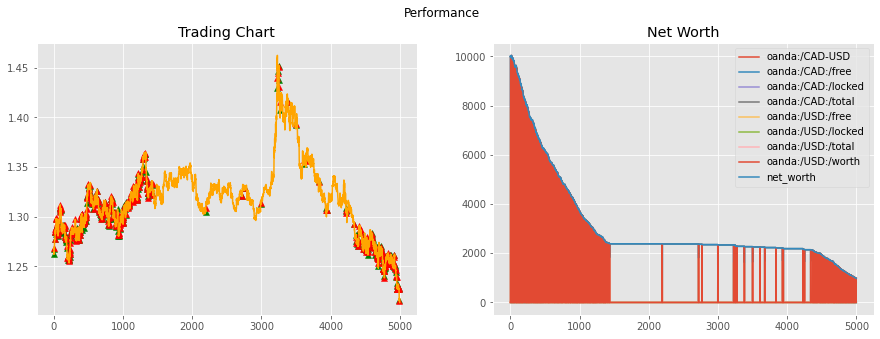

In [10]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

In [11]:
from pandasgui import show

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')

gui = show(performance)

In [12]:
gui = show(env.action_scheme.portfolio.ledger.as_frame())